<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="200" align="right" style="height:240px">

##ColabFold v1.5.2-patch: AlphaFold2 using MMseqs2

Easy to use protein structure and complex prediction using [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) and [Alphafold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). Sequence alignments/templates are generated through [MMseqs2](mmseqs.com) and [HHsearch](https://github.com/soedinglab/hh-suite). For more details, see <a href="#Instructions">bottom</a> of the notebook, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and read our manuscript.
Old versions: [v1.4](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.4.0/AlphaFold2.ipynb), [v1.5.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.1/AlphaFold2.ipynb)

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

-----------

### News
- <b><font color='red'>2023/07/27: ColabFold MSA server issue: We are using the backup server with old databases (UniRef30 2202/PDB70 220313) starting from ~8:30 AM CEST until we resolve the issue.</font></b>
- <b><font color='green'>2023/06/12: New databases! UniRef30 updated to 2023_02 and PDB to 230517. We now use PDB100 instead of PDB70 (see [notes](#pdb100)).</font></b>
- <b><font color='green'>2023/06/12: We introduced a new default pairing strategy: Previously, for multimer predictions with more than 2 chains, we only pair if all sequences taxonomically match ("complete" pairing). The new default "greedy" strategy pairs any taxonomically matching subsets.</font></b>

In [1]:
#########################
###### Job Options ######
#########################

query_sequence = 'PIAQIHILEGRSDEQ' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = "job_name"
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "none" #@param ["none", "pdb100"]

#########################
###### MSA Options ######
#########################
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence"]
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "auto" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use 20 recycles if `model_type=alphafold2_multimer_v3` (with tol=0.5), all else 3 recycles (with tol=0.0).
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.

#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive

##########################
#### Image Resolution ####
##########################
dpi = 300 #@param {type:"integer"}

display_images = True #@param {type:"boolean"}

# sequence_to_structure_alphafold(query_sequence="",
#                                 jobname="",
#                                 num_relax=0,
#                                 template_mode=None,
#                                 msa_mode = "mmseqs2_uniref_env",
#                                 pair_mode = "unpaired_paired",
#                                 model_type = "auto",
#                                 num_recycles = "auto",
#                                 recycle_early_stop_tolerance = "auto",
#                                 pairing_strategy = "greedy",
#                                 max_msa = "auto",
#                                 num_seeds = 1,
#                                 save_all = False,
#                                 save_recycles = False,
#                                 use_dropout = False,
#                                 dpi = 300,
#                                 display_images = True
#                                 )


###########################
#### Process Variables ####
###########################
num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": 
    max_msa = None

In [2]:
#######################
### LIBRARY IMPORTS ###
#######################
# No point in continuing if the libraries aren't all available!
# from google.colab import files
import os
import numpy as np
import re
import hashlib
import random
from pathlib import Path
import matplotlib.pyplot as plt
import sys
import glob
import warnings
from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"
warnings.simplefilter(action='ignore', category=FutureWarning)

from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)

from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2
from colabfold.colabfold import plot_protein


#@title Display 3D structure {run: "auto"}
##############################
#### Display 3D structure ####
##############################
import py3Dmol
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list



In [3]:
############################
### FUNCTION DEFINITIONS ###
############################
def add_hash(x,y):
    return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

# check if directory with jobname exists
def check(folder):
    if os.path.exists(folder):
        return False
    else:
        return True
    
def input_features_callback(input_features):
    if display_images:
        plot_msa_v2(input_features)
        plt.show()
        plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
    model_name, relaxed = mode
    if not relaxed:
        if display_images:
            fig = plot_protein(protein_obj, Ls=length, dpi=150)
            plt.show()
            plt.close()


In [4]:
use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())
basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

if not check(jobname):
    n = 0
    while not check(f"{jobname}_{n}"): n += 1
    jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
    text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
    use_templates = True
    custom_template_path = None
else:
    custom_template_path = None
    use_templates = False



In [5]:
#@title Install dependencies
# %%time
# USE_AMBER = use_amber
# USE_TEMPLATES = use_templates
# PYTHON_VERSION = python_version

# if not os.path.isfile("COLABFOLD_READY"):
#     print("installing colabfold...")
#     os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
#     os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
#     os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
#     # patch for jax > 0.3.25
#     os.system("sed -i 's/weights = jax.nn.softmax(logits)/logits=jnp.clip(logits,-1e8,1e8);weights=jax.nn.softmax(logits)/g' alphafold/model/modules.py")
#     os.system("touch COLABFOLD_READY")

# if USE_AMBER or USE_TEMPLATES:
#     if not os.path.isfile("CONDA_READY"):
#         print("installing conda...")
#         os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
#         os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
#         os.system("mamba config --set auto_update_conda false")
#         os.system("touch CONDA_READY")

# if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
#     print("installing hhsuite and amber...")
#     os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
#     os.system("touch HH_READY")
#     os.system("touch AMBER_READY")
# else:
#     if USE_TEMPLATES and not os.path.isfile("HH_READY"):
#         print("installing hhsuite...")
#         os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
#         os.system("touch HH_READY")
#     if USE_AMBER and not os.path.isfile("AMBER_READY"):
#         print("installing amber...")
#         os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
#         os.system("touch AMBER_READY")

In [6]:
# decide which a3m to use
if "mmseqs2" in msa_mode:
    a3m_file = os.path.join(jobname,f"{jobname}.a3m")

else:
    a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
    with open(a3m_file, "w") as text_file:
        text_file.write(">1\n%s" % query_sequence)

2023-07-27 14:43:16,514 Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-07-27 14:43:16,516 Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-07-27 14:43:16,516 Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-07-27 14:43:16,517 No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023-07-27 14:43:16,517 WARNING: no GPU detected, will be using CPU
2023-07-27 14:43:17,331 Found 4 citations for tools or databases
2023-07-27 14:43:17,331 Query 1/1: job_name_13d99 (length 15)


PENDING:   0%|          | 0/150 [elapsed: 00:00 remaining: ?]

2023-07-27 14:43:17,920 Sleeping for 9s. Reason: PENDING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:10 remaining: 00:00]


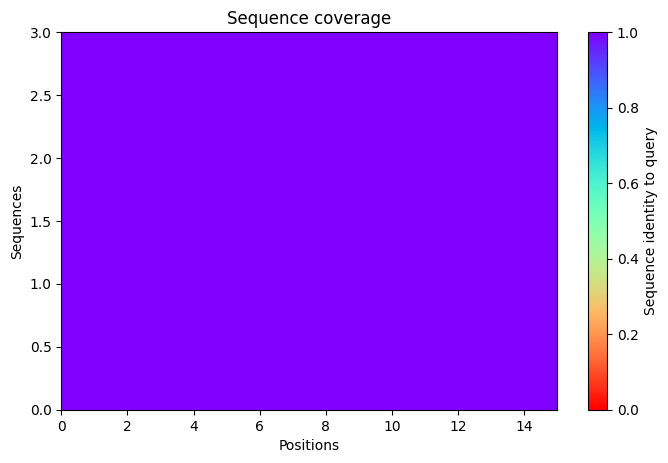

2023-07-27 14:43:28,242 Setting max_seq=3, max_extra_seq=1
2023-07-27 14:43:39,433 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=73.9 pTM=0.0309
2023-07-27 14:43:39,958 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=73.9 pTM=0.0311 tol=0.312
2023-07-27 14:43:40,467 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=73.8 pTM=0.0312 tol=0.313
2023-07-27 14:43:40,983 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=76.6 pTM=0.0322 tol=0.456
2023-07-27 14:43:40,983 alphafold2_ptm_model_1_seed_000 took 9.9s (3 recycles)


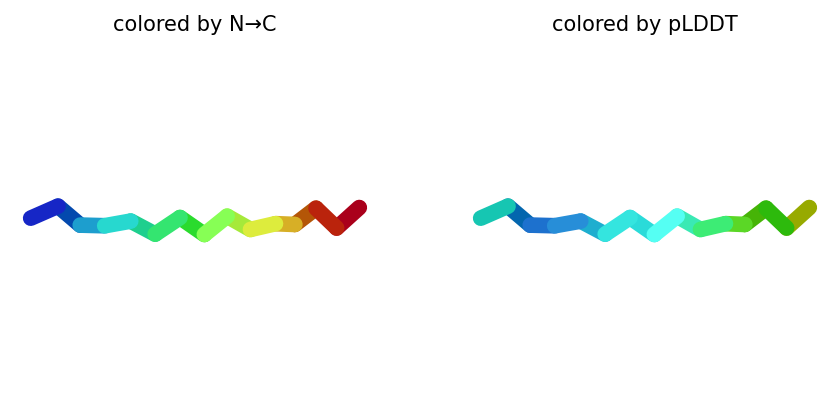

2023-07-27 14:43:41,546 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=72.6 pTM=0.0302
2023-07-27 14:43:42,069 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=74.1 pTM=0.0293 tol=0.488
2023-07-27 14:43:42,580 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=74.1 pTM=0.0292 tol=0.23
2023-07-27 14:43:43,095 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=76.6 pTM=0.0298 tol=0.177
2023-07-27 14:43:43,096 alphafold2_ptm_model_2_seed_000 took 2.1s (3 recycles)


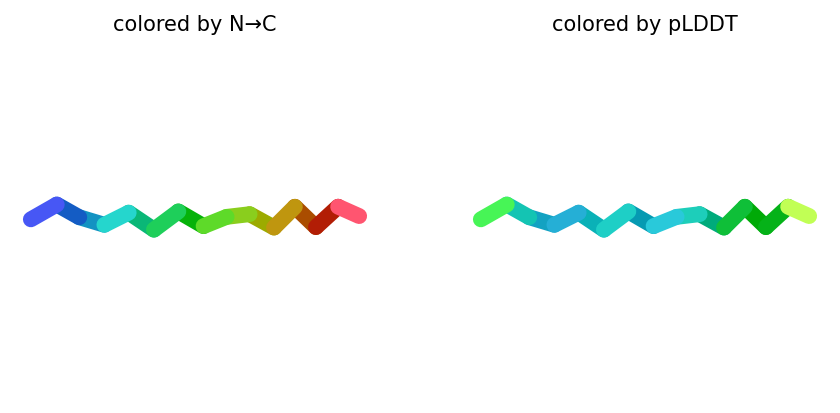

2023-07-27 14:43:43,652 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=77.8 pTM=0.0298
2023-07-27 14:43:44,173 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=78.8 pTM=0.03 tol=0.256
2023-07-27 14:43:44,691 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=80.1 pTM=0.0303 tol=0.12
2023-07-27 14:43:45,214 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=81.7 pTM=0.031 tol=0.303
2023-07-27 14:43:45,215 alphafold2_ptm_model_3_seed_000 took 2.1s (3 recycles)


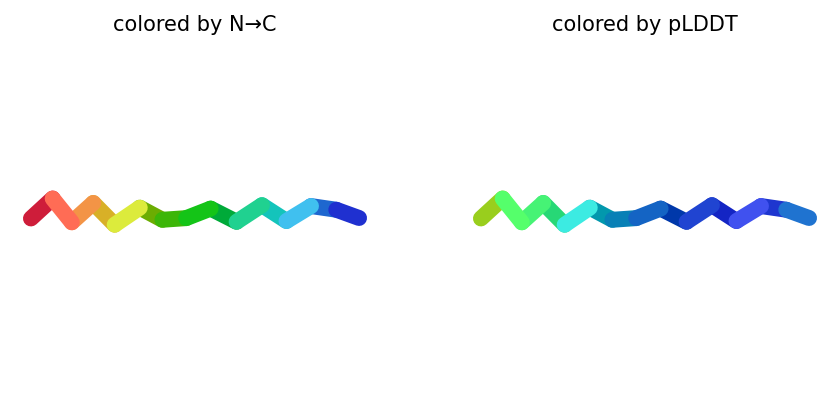

2023-07-27 14:43:45,849 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=76.4 pTM=0.0304
2023-07-27 14:43:46,361 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=75.9 pTM=0.0296 tol=0.378
2023-07-27 14:43:46,882 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=76.6 pTM=0.0293 tol=0.0865
2023-07-27 14:43:47,401 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=77.6 pTM=0.03 tol=0.155
2023-07-27 14:43:47,401 alphafold2_ptm_model_4_seed_000 took 2.1s (3 recycles)


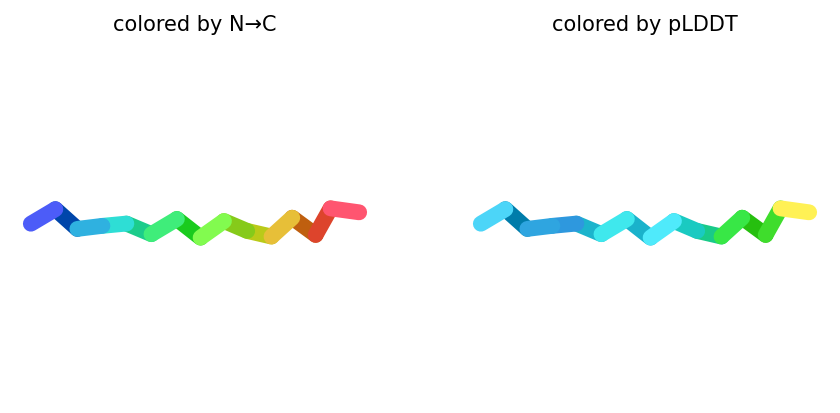

2023-07-27 14:43:47,988 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=75.1 pTM=0.0302
2023-07-27 14:43:48,497 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=75.4 pTM=0.0295 tol=0.335
2023-07-27 14:43:48,990 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=75.9 pTM=0.0294 tol=0.102
2023-07-27 14:43:49,496 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=78.8 pTM=0.0304 tol=0.349
2023-07-27 14:43:49,496 alphafold2_ptm_model_5_seed_000 took 2.1s (3 recycles)


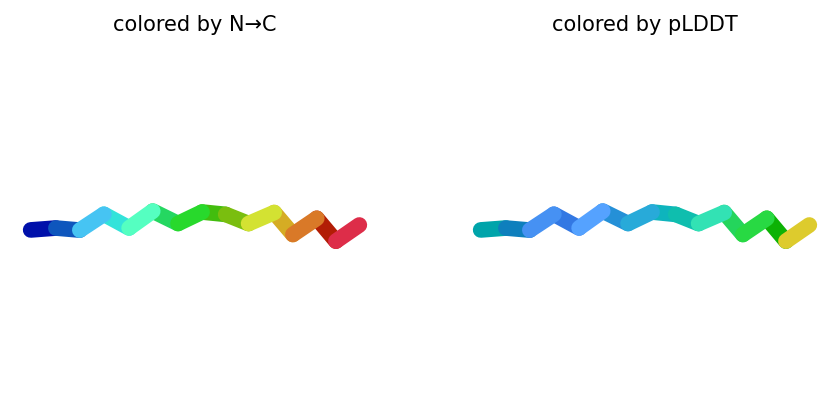

2023-07-27 14:43:49,536 reranking models by 'plddt' metric
2023-07-27 14:43:49,536 rank_001_alphafold2_ptm_model_3_seed_000 pLDDT=81.7 pTM=0.031
2023-07-27 14:43:49,536 rank_002_alphafold2_ptm_model_5_seed_000 pLDDT=78.8 pTM=0.0304
2023-07-27 14:43:49,536 rank_003_alphafold2_ptm_model_4_seed_000 pLDDT=77.6 pTM=0.03
2023-07-27 14:43:49,536 rank_004_alphafold2_ptm_model_2_seed_000 pLDDT=76.6 pTM=0.0298
2023-07-27 14:43:49,536 rank_005_alphafold2_ptm_model_1_seed_000 pLDDT=76.6 pTM=0.0322
2023-07-27 14:43:50,423 Done
  adding: job_name_13d99/ (stored 0%)
  adding: job_name_13d99/job_name_13d99_pae.png (deflated 28%)
  adding: job_name_13d99/job_name_13d99_predicted_aligned_error_v1.json (deflated 59%)
  adding: job_name_13d99/job_name_13d99_env/ (stored 0%)
  adding: job_name_13d99/job_name_13d99_env/out.tar.gz (stored 0%)
  adding: job_name_13d99/job_name_13d99_env/bfd.mgnify30.metaeuk30.smag30.a3m (deflated 20%)
  adding: job_name_13d99/job_name_13d99_env/pdb70.m8 (deflated 46%)
  addin

0

In [7]:
result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
if not os.path.isfile(log_filename) or 'logging_setup' not in globals():
    setup_logging(Path(log_filename))
    logging_setup = True

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
    use_cluster_profile = False
else:
    use_cluster_profile = True

download_alphafold_params(model_type, Path("."))  # Can I do this for each model type option above and then just have it done at the start of the service?
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

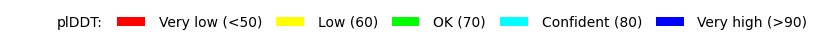

In [8]:
##############################
#### Display 3D Structure ####
##############################
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
    model_name = f"rank_{rank_num}"
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
    view.addModel(open(pdb_file[0],'r').read(),'pdb')

    if color == "lDDT":
        view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
    elif color == "rainbow":
        view.setStyle({'cartoon': {'color':'spectrum'}})
    elif color == "chain":
        chains = len(queries[0][1]) + 1 if is_complex else 1
        for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
            view.setStyle({'chain':chain},{'cartoon': {'color':color}})

    if show_sidechains:
        BB = ['C','O','N']
        view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                            {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
        view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                            {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
        view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                            {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    if show_mainchains:
        BB = ['C','O','N','CA']
        view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

    view.zoomTo()
    return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
    plot_plddt_legend().show()